# Solving OBEs using matrix methods
This document is about solving the optical bloch equations.
Mathematically, we can apply the fourier transform for the OBEs and noticing that the OBEs are linear we can solve them by finding the eigenvalues and eigenvectors. We note that are the general solutions are superpositions of several 'normal modes'. 

In [3]:

import matplotlib.pyplot as plt  # Import library for direct plotting functions
import numpy as np  # Import Numerical Python
from IPython.display import display, HTML  # Import HTML for formatting output
from scipy.integrate import ode  # Import ODE solver
import scipy.constants as cts  # Import physical constants
from arc import *
from equations import *
from solver import *
from scipy.integrate import solve_ivp

In [4]:
# Define two-level OBEs matrix

def two_level_OBEs_matrix(Gamma, Omega, gamma_perp, Delta):
    # frhos = [rhof_ee, rhof_gg, frho_eg, frho_ge]
    
    obef = -1j*np.array([[-Gamma, 0, 1j*Omega/2, -1j*Omega/2],
                     [Gamma, 0, -1j*Omega/2, 1j*Omega/2],
                     [1j*Omega/2, -1j*Omega/2, -(gamma_perp + 1j*Delta), 0],
                     [-1j*Omega/2, +1j*Omega/2, 0, -(gamma_perp-1j*Delta)]], dtype=complex)
    
    return obef

c:\Users\clu28\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


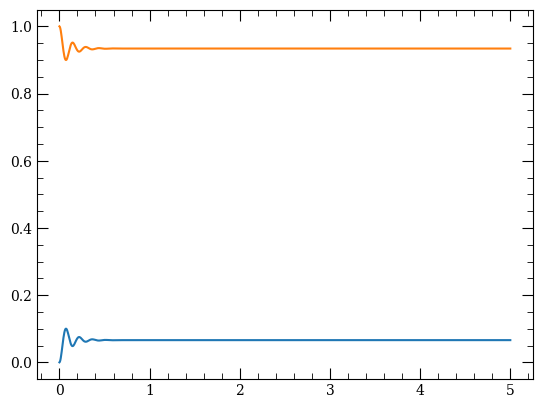

In [5]:
Gamma = 9
gamma_perp = Gamma
Delta = 40
Omega = 16
y0 = np.array([0,1+0j,0,0],dtype=complex)
obef = two_level_OBEs_matrix(Gamma, Omega, gamma_perp, Delta)
#print(obef)
det = np.linalg.det(obef)
#print(det)
# Find the eigenvalues and eigenvectors of the matrix
w, v = eig(obef)

#print('w'+str(w))
#print(v)
#print(v[:,0])

# Find the coefficients of the initial state in the eigenbasis
c = np.linalg.solve(v, y0)

#print(c)

t = np.linspace(0, 5, 1000)

rho_ee = c[0]*v[0,0]*np.exp(1j*w[0]*t) + c[1]*v[0,1]*np.exp(1j*w[1]*t) + \
c[2]*v[0,2]*np.exp(1j*w[2]*t) + c[3]*v[0,3]*np.exp(1j*w[3]*t)

rho_gg = c[0]*v[1,0]*np.exp(1j*w[0]*t) + c[1]*v[1,1]*np.exp(1j*w[1]*t) + \
c[2]*v[1,2]*np.exp(1j*w[2]*t) + c[3]*v[1,3]*np.exp(1j*w[3]*t)
plt.plot(t, rho_ee)

plt.plot(t, rho_gg)





Next we try to solve the three-level optical bloch equations.

In [6]:
# Define three-level OBEs

def three_level_OBEs_matrix(Omega1, Omega2, gamma1, gamma2, delta1, delta2, b1, b2):
    # frhos = [frho_ee, frho_ii, frho_gg, frho_ei, frho_ie, frho_ig, frho_gi, frho_eg, frho_ge]
    obef3 = -1j*np.array([[-gamma2,0,0,1j/2*Omega2,-1j/2*Omega2, 0, 0, 0, 0], 
                     [b2*gamma2,-gamma1,0, -1j/2*Omega2, 1j/2*Omega2, 1j/2*Omega1, -1j/2*Omega1, 0, 0],
                     [0, b1*gamma1, 0, 0, 0, -1j/2*Omega1, 1j/2*Omega1, 0, 0],
                     [1j/2*Omega2, -1j/2*Omega2, 0, (-(gamma2+gamma1)/2+1j*delta2), 0, 0, 0, 1j/2*Omega1, 0],
                     [-1j/2*Omega2, 1j/2*Omega2, 0, 0, (-(gamma2+gamma1)/2-1j*delta2), 0, 0, 0, -1j/2*Omega1],
                     [0, 1j/2*Omega1, -1j/2*Omega1, 0, 0, -gamma1/2+1j*delta1, 0, -1j/2*Omega2, 0],
                     [0, -1j/2*Omega1, 1j/2*Omega1, 0, 0, 0, -gamma1/2-1j*delta1, 0, 1j/2*Omega2],
                     [0, 0, 0, 1j/2*Omega1, 0, -1j/2*Omega2, 0, -gamma2/2+1j*(delta1+delta2),0],
                     [0, 0, 0, 0, -1j/2*Omega1, 0, 1j/2*Omega2, 0,-gamma2/2-1j*(delta1+delta2)]],dtype=complex)
    
    return obef3


    









We first write down relevant parameters and use ARC to calculate the corresponding quantities:

In [7]:
# Laser power and waist
P1 = 2e-6  # Laser1 power in W
W1 = 42e-6  # Laser1 waist in m
P2 = 2e-3  # Laser2 power in W
W2 = 9e-6  # Laser2 waist in m
# Some experimental parameters and constants
I1= P1/(np.pi*(W1)**2) #Intensity of the probe laser in W/m^2
I2= P2/(np.pi*(W2)**2)#Intensity of the coupling laser in W/m^2
a_0 = cts.physical_constants['Bohr radius'][0]  # Bohr radius in meters
e = cts.e  # Electron charge in Coulombs  
hbar = cts.hbar  # Planck's constant divided by 2*pi in J*s 
epsilon = cts.epsilon_0  # Vacuum permittivity in Farads/meter
c = cts.c  # Speed of light in meters/second
E1 = np.sqrt(2*I1/(epsilon*c)) # Strength of the probe electric field in V/m
E2 = np.sqrt(2*I2/(epsilon*c)) # Strength of the coupling electric field in V/m
print('E1=' + str(E1))
print('E2=' + str(E2))
# For Rb, we chose g,i,e as 5S1/2, 5P3/2, 5D5/2
# Note: All frequencies below are in radian per second
atom = Rubidium()
# Ground state, 5S1/2
ng = 5
lg = 0
jg = 1/2
fg = 2
mfg = 2
mjg = 1/2
# Intermdiate state, 5P3/2
ni = 5
li = 1
ji = 3/2
fi = 3
mfi = 3
mji = 1/2
# Final state, 60S1/2
nf = 60
lf = 0
ff = 1
mff = 1
jf = 1/2
mjf = 1/2
# Branching ratios
#b1 = atom.getBranchingRatio(jg = jg, fg = fg, mfg = mfg,
 #                               je = ji, fe = fi, mfe = mfi)
#b2 = atom.getBranchingRatio(jg = ji, fg = fi, mfg = mfi,
                               #je = jf, fe = ff, mfe = mff)
#?not sure how to calculate the branching ratio from the ARC?
b1=1 # here we just assume that b1=1, b2=0
b2=0
print('b1='+ str(b1))
print('b2='+ str(b2))

E1=521.4600626830742
E2=76953.40365499211


b1=1
b2=0


In [8]:
# Dipole Moment
dgi = atom.getDipoleMatrixElement(n1= ng, l1= lg, j1= jg, mj1= mjg,
                                    n2= ni, l2= li, j2= ji, mj2= mji, q=0)
print('dgi='+ str("{:e}".format(dgi)))


#Rabi Frequency 1e6-100e6
Omega1 = atom.getRabiFrequency2(n1= ng, l1= lg, j1= jg, mj1= mjg, 
                                    n2= ni, l2= li, j2= ji, q=0 ,
                                    electricFieldAmplitude= E1)


Omega2 = atom.getRabiFrequency2(n1= ni, l1= li, j1= ji, mj1= mji,
                                    n2= nf, l2= lf, j2= jf, q=0,
                                    electricFieldAmplitude= E2)


print("Omega1=2*pi*"+ str("{:e}".format(Omega1/(2*np.pi))) + 'Hz'+'='+ str("{:e}".format(Omega1)))
print('Omega2=2*pi*'+ str("{:e}".format(Omega2/(2*np.pi)))+ 'Hz'+'='+ str("{:e}".format(Omega2)))

# Transition frequency
omega01 = 2*np.pi*atom.getTransitionFrequency(n1= ng, l1= lg, j1= jg, 
                                    n2= ni, l2= li, j2= ji)
omega02 = 2*np.pi*atom.getTransitionFrequency(n1= ni, l1= li, j1= ji,
                                    n2= nf, l2= lf, j2= jf)

print('omega01=2*pi*'+ str("{:e}".format(omega01/(2*np.pi))) + 'Hz'+'='+ str("{:e}".format(omega01)))
print('omega02=2*pi*'+ str("{:e}".format(omega02/(2*np.pi)))+ 'Hz'+'='+ str("{:e}".format(omega02)))

# Laser frequency

lambda1 = 780e-9
lambda2 = 480e-9
omega1 = 2*np.pi*c/lambda1
omega2 = 2*np.pi*c/lambda2
print('omega1=2*pi*'+ str("{:e}".format(omega1/(2*np.pi))) + 'Hz'+'='+ str("{:e}".format(omega1)))
print('omega2=2*pi*'+ str("{:e}".format(omega2/(2*np.pi)))+ 'Hz'+'='+ str("{:e}".format(omega2)))

# Detuning

#delta1 =  omega1 - omega01
#delta2 =  omega2 - omega02 
delta1 = 2*np.pi*400e6 # detuning between the intermediate state and the ground state
delta2 = -delta1 # detuning between the intermediate state and the final state
delta = delta1+delta2 # total detuning between the ground state and the final state
deltaeff = (delta1+delta2)-(np.abs(Omega1)**2-np.abs(Omega2)**2)/(4*(delta1))
deltashift = (np.abs(Omega1)**2-np.abs(Omega2)**2)/(4*(delta1))

print('delta1=2*pi*'+ str("{:e}".format(delta1/(2*np.pi))) + 'Hz'+'='+ str("{:e}".format(delta1)))
print('delta2=2*pi*'+ str("{:e}".format(delta2/(2*np.pi)))+ 'Hz'+'='+ str("{:e}".format(delta2))) 
print('delta=2*pi*'+ str("{:e}".format(delta/(2*np.pi)))+ 'Hz'+'='+ str("{:e}".format(delta)))
print('deltaeff=2*pi*'+ str("{:e}".format(deltaeff/(2*np.pi)))+ 'Hz'+'='+ str("{:e}".format(deltaeff)))
print('deltashift=2*pi*'+ str("{:e}".format(deltashift/(2*np.pi)))+ 'Hz'+'='+ str("{:e}".format(deltashift)))

'''
m1 = 20
m2 = -2
delta1 = m1 * Omega1
delta2 = m2 * Omega2
delta1 = 1e7
delta2 = -delta1 
'''
'''
Omegaeff = Omega1*Omega2/(2*delta1)

period = 2*np.pi/Omegaeff

print('Omegaeff=2*pi*'+ str("{:e}".format(Omegaeff/(2*np.pi)))+ 'Hz'+'='+ str("{:e}".format(Omegaeff)))
print('period='+ str("{:e}".format(period)))
'''


# Sponetaous Decay rates
gamma1 = 1/atom.getStateLifetime(n = ni, l = li, j = ji)
print('lifetime='+str("{:e}".format(atom.getStateLifetime(n = ni, l = li, j = ji))))
gamma2 = 1/atom.getStateLifetime(n = nf, l = lf, j = jf)
print('lifetime='+str("{:e}".format(atom.getStateLifetime(n = nf, l = lf, j = jf))))


print('gamma1='+ str("{:e}".format(gamma1)))
print('gamma2='+ str("{:e}".format(gamma2)))

dgi=-2.440631e+00
Omega1=2*pi*1.628466e+07Hz=1.023195e+08
Omega2=2*pi*4.856034e+06Hz=3.051136e+07
omega01=2*pi*3.842304e+14Hz=2.414191e+15
omega02=2*pi*6.247771e+14Hz=3.925590e+15
omega1=2*pi*3.843493e+14Hz=2.414938e+15
omega2=2*pi*6.245676e+14Hz=3.924274e+15
delta1=2*pi*4.000000e+08Hz=2.513274e+09
delta2=2*pi*-4.000000e+08Hz=-2.513274e+09
delta=2*pi*0.000000e+00Hz=0.000000e+00
deltaeff=2*pi*-1.510056e+05Hz=-9.487963e+05
deltashift=2*pi*1.510056e+05Hz=9.487963e+05
lifetime=2.623766e-08
lifetime=2.303017e-04
gamma1=3.811316e+07
gamma2=4.342130e+03


In [9]:
# Parameters

delta2 = 5
delta = (np.abs(Omega2)**2-np.abs(Omega1)**2)/(4*(delta1))
delta2 = delta - delta1
omegaeff = Omega1*Omega2/(2*delta1)
y0 = np.array([0,0,1+0J,0,0,0,0,0,0],dtype=complex)
print(omegaeff)
print(delta2)
print('delta2='+ str("{:e}".format(delta2)))





621083.8270395184
-2514222919.2168636
delta2=-2.514223e+09


[ 2.51575877e+09+1.90659486e+07j  2.51513845e+09+1.90565601e+07j
 -2.51575877e+09+1.90659486e+07j -2.51513845e+09+1.90565601e+07j
  4.27981533e-07+3.80802321e+07j  6.20634669e+05+7.16283852e+03j
 -6.20634669e+05+7.16283852e+03j -2.75112325e-09+2.17022692e+03j
 -3.16060079e-10+1.07614379e+04j]
[-1.43837893e-02+2.17895857e-04j -1.43781556e-02+5.90708442e-04j
 -1.43837893e-02-2.17895857e-04j -1.43781556e-02-5.90708442e-04j
  5.84905724e-04+5.63525721e-15j  5.00017660e-01-2.87286771e-03j
  5.00017660e-01+2.87286771e-03j  8.06177029e-01-5.00414712e-14j
  3.86597881e-01+2.92634917e-03j]


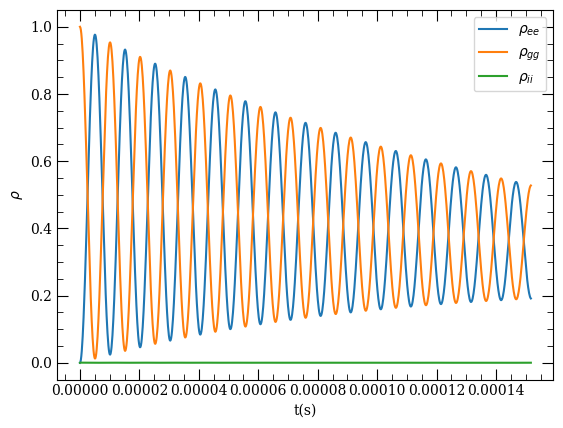

In [10]:

obef3 = three_level_OBEs_matrix(Omega1, Omega2, gamma1, gamma2, delta1, delta2, b1, b2)

w, v = eig(obef3)
print(w)
c = np.linalg.solve(v, y0)
print(c)
t = np.linspace(0, 30*np.pi/omegaeff, 1000)

rho_ee = c[0]*v[0,0]*np.exp(1j*w[0]*t) + c[1]*v[0,1]*np.exp(1j*w[1]*t) + \
c[2]*v[0,2]*np.exp(1j*w[2]*t) + c[3]*v[0,3]*np.exp(1j*w[3]*t) + \
c[4]*v[0,4]*np.exp(1j*w[4]*t) + c[5]*v[0,5]*np.exp(1j*w[5]*t) + \
c[6]*v[0,6]*np.exp(1j*w[6]*t) + c[7]*v[0,7]*np.exp(1j*w[7]*t) + \
c[8]*v[0,8]*np.exp(1j*w[8]*t)

rho_gg = c[0]*v[2,0]*np.exp(1j*w[0]*t) + c[1]*v[2,1]*np.exp(1j*w[1]*t) + \
c[2]*v[2,2]*np.exp(1j*w[2]*t) + c[3]*v[2,3]*np.exp(1j*w[3]*t)+\
c[4]*v[2,4]*np.exp(1j*w[4]*t) + c[5]*v[2,5]*np.exp(1j*w[5]*t) + \
c[6]*v[2,6]*np.exp(1j*w[6]*t) + c[7]*v[2,7]*np.exp(1j*w[7]*t) + \
c[8]*v[2,8]*np.exp(1j*w[8]*t)

rho_ii = c[0]*v[1,0]*np.exp(1j*w[0]*t) + c[1]*v[1,1]*np.exp(1j*w[1]*t) + \
c[2]*v[1,2]*np.exp(1j*w[2]*t) + c[3]*v[1,3]*np.exp(1j*w[3]*t)+\
c[4]*v[1,4]*np.exp(1j*w[4]*t) + c[5]*v[1,5]*np.exp(1j*w[5]*t) + \
c[6]*v[1,6]*np.exp(1j*w[6]*t) + c[7]*v[1,7]*np.exp(1j*w[7]*t) + \
c[8]*v[1,8]*np.exp(1j*w[8]*t)


plt.plot(t, rho_ee, label = r'$\rho_{ee}$')

plt.plot(t, rho_gg,label = r'$\rho_{gg}$')

plt.plot(t, rho_ii,label = r'$\rho_{ii}$')

plt.xlabel('t(s)')
plt.ylabel(r'$\rho$')
plt.legend()
plt.show()

